---
## Import required libraries

In [171]:
import contextily as cx
import geopandas as gpd
from geopy.distance import geodesic as GD
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import rioxarray
import seaborn as sns
from scipy.integrate import quad
from scipy.signal import argrelextrema
from spectral.io import envi

---
## Function to open files, storing relevant data in variables

In [172]:
def enviread(datafile, hdrfile):
   info = envi.open(hdrfile, datafile)
   data = info.load()
   return np.array(data), info

In [173]:
# L1 Geo data - latitude & longitude for each pixel in 2000 by 128 pixel area
path_L1_dat = 'Flight 2020-06-18 (methane)/L1/014_200618_215511_UI_R293X04_10ka090_36_Whisk9_geo.dat'
path_L1_hdr = 'Flight 2020-06-18 (methane)/L1/014_200618_215511_UI_R293X04_10ka090_36_Whisk9_geo.hdr'

[data_L1, info_L1] = enviread(path_L1_dat, path_L1_hdr)

latitudes = data_L1[:, :, 1]
longitudes = data_L1[:, :, 0]

In [174]:
# L2S spectral and spacial pixel coordinate data - values are radiances in units of microflicks (1 μf ≡ 1 μWcm−2 sr−1 μm−1)
path_L2S_dat = 'Flight 2020-06-18 (methane)/L2/014_200618_215511_UI_R293X04_10ka090_36_Whisk9_L2S.dat'
path_L2S_hdr = 'Flight 2020-06-18 (methane)/L2/014_200618_215511_UI_R293X04_10ka090_36_Whisk9_L2S.hdr'

[data_L2S, info_L2S] = enviread(path_L2S_dat, path_L2S_hdr)

In [175]:
# L2 aux
path_aux_dat = 'Flight 2020-06-18 (methane)/L2/014_200618_215511_UI_R293X04_10ka090_36_Whisk9_aux.dat'
path_aux_hdr = 'Flight 2020-06-18 (methane)/L2/014_200618_215511_UI_R293X04_10ka090_36_Whisk9_aux.hdr'

[data_aux, info_aux] = enviread(path_aux_dat, path_aux_hdr)

In [176]:
# L3 ACE filter
path_ACE_dat = 'Flight 2020-06-18 (methane)/L3/014_200618_215511_UI_R293X04_10ka090_36_Whisk9_ACE.dat'
path_ACE_hdr = 'Flight 2020-06-18 (methane)/L3/014_200618_215511_UI_R293X04_10ka090_36_Whisk9_ACE.hdr'

[data_ACE, info_ACE] = enviread(path_ACE_dat, path_ACE_hdr)

In [177]:
# L3 temperature data
path_temp_dat = 'Flight 2020-06-18 (methane)/L3/014_200618_215511_UI_R293X04_10ka090_36_Whisk9_BTEMP.dat'
path_temp_hdr = 'Flight 2020-06-18 (methane)/L3/014_200618_215511_UI_R293X04_10ka090_36_Whisk9_BTEMP.hdr'

[data_temp, info_temp] = enviread(path_temp_dat, path_temp_hdr)

---
## Quantification: Converting from observed radiance to concentration of methane

/var/folders/25/8np84kys483f0_7dwd205zkh0000gn/T/ipykernel_60804/3218331012.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot1 = ax.pcolormesh(-latitudes,longitudes,data_ACE[:,:,66],cmap='Greys_r', vmin=channel_mean-channel_4_sigma,vmax=channel_mean+channel_4_sigma)


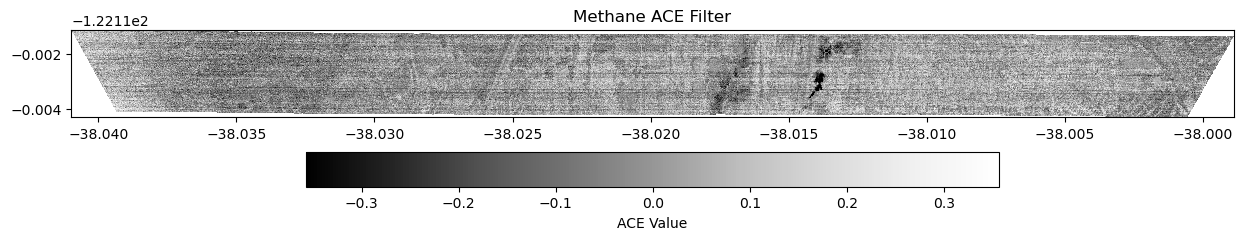

In [178]:
# Channel 66 of the ACE filter is for methane

# Plotting the methane ACE filter output as described in figure 5 of Buckland et. al.: gray-scale using a linear stretch of 4 sigma
fig, ax = plt.subplots(figsize=(15, 3))  

channel_mean = data_ACE[:,:,66].mean()
channel_4_sigma = 4*data_ACE[:,:,66].std()

plot1 = ax.pcolormesh(-latitudes,longitudes,data_ACE[:,:,66],cmap='Greys_r', vmin=channel_mean-channel_4_sigma,vmax=channel_mean+channel_4_sigma)
plt.colorbar(plot1, ax = ax, label='ACE Value',location='bottom')

ax.set_aspect('equal')
plt.title(f'Methane ACE Filter')
plt.show()

In [179]:
# The absolute max ACE value is the pixel location most likely to have some methane (maximum significance = max sig)
np.argmax(np.absolute(data_ACE[:, :, 66]))

# This result is flattened so we need to "unravel" it to give the original dimensions for the max sig pixel location
max_sig_index = np.unravel_index(np.argmax(np.absolute(data_ACE[:, :, 66])), data_ACE[:, :, 66].shape)
max_sig_index

(1334, 85)

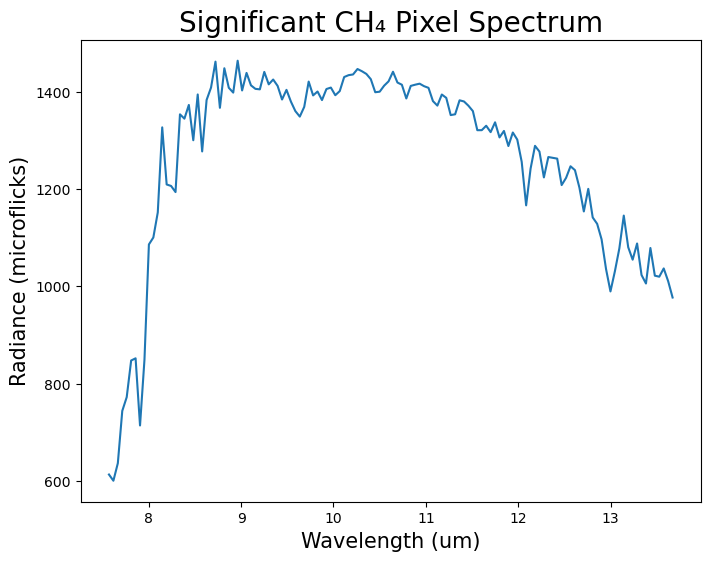

In [180]:
# Plot the spectrum of radiance vs wavelength for the max sig pixel found above
fig, ax = plt.subplots(figsize=(8,6))

# Wavelengths are measured from 7.57 um to 13.67 um with 128 distinct values
wavelengths = np.linspace(7.57, 13.67, 128)
ax.plot(wavelengths, data_L2S[max_sig_index])

ax.set_xlabel('Wavelength (um)', fontsize=15)
ax.set_ylabel('Radiance (microflicks)', fontsize=15)
ax.set_title('Significant CH\u2084 Pixel Spectrum', fontsize=20)
ax.tick_params(axis='both', labelsize=10)
plt.show()

In [181]:
# We want the transmittance spectrum, so we find the blackbody radiance at that pixel using the Planck function (in units of microflicks) given by the Buckland et. al. paper and the temperature data
def Planck(wavelength, temp):
    return ((1.19104*1e10)/wavelength**5)*(np.exp(14387.7/(wavelength*temp))-1)**-1

<img src='Images/applied_Beer-Lambert_law.png' align='center' width='700px'>

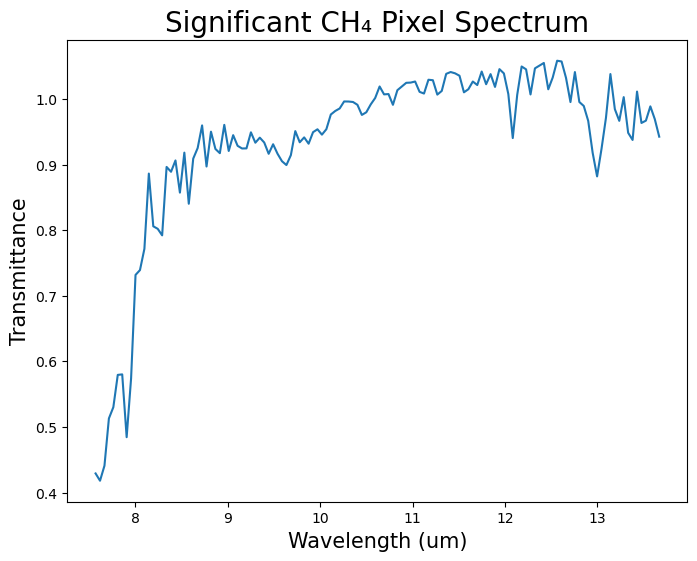

In [182]:
# Plot the spectrum of radiance vs wavelength for the max sig pixel found above
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(wavelengths_um, data_L2S[max_sig_index]/Planck(wavelengths, data_temp[max_sig_index]+273.15))

ax.set_xlabel('Wavelength (um)', fontsize=15)
ax.set_ylabel('Transmittance', fontsize=15)
ax.set_title('Significant CH\u2084 Pixel Spectrum', fontsize=20)
ax.tick_params(axis='both', labelsize=10)
plt.show()

We ultimately want to find the concentration of methane for a given transmittance. To do this, we are going to use [MODTRAN](http://modtran.spectral.com/modtran_home), an atmospheric transmission simulator, to fit a model of transmittance versus concentration of methane. We want to fit this model at a strong absorption feature for methane, which we can identify from our transmittance spectrum.

In [183]:
# Identify the feature of greatest interest and find its location (in our case, the second local minimum on the graph)
local_mins = argrelextrema(data_L2S[max_sig_index], np.less)[0]
series = pd.Series(local_mins)
feature_radiance = data_L2S[max_sig_index][series[1]]
feature_wavelength = wavelengths_um[series[1]]
print(f'The feature of interest is at {feature_wavelength:.2f} um and {feature_radiance:.2f} microflicks.')

The feature of interest is at 7.91 um and 714.08 microflicks.


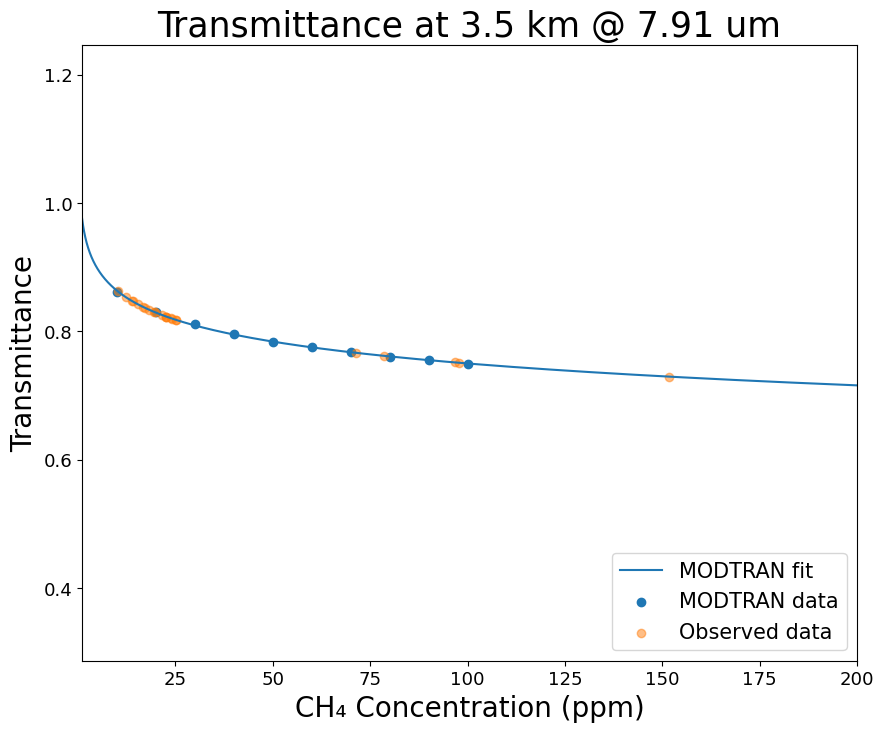

In [184]:
# We used MODTRAN to find the radiance at intervals of 10 ppm from 0 to 100 ppm methane
MODTRAN_radiance = np.array([762.65, 685.25, 659.8, 645.95, 632.55, 623.55, 616.7, 610.8, 604.4, 600.35, 596.2])[1:]
concentration = np.linspace(0, 100, 11)[1:]

# MODTRAN transmittance = MODTRAN radiance values / Earth's blackbody radiation
modtran_blackbody_radiation = Planck(feature_wavelength, 294.2)
MODTRAN_transmittance = MODTRAN_radiance/modtran_blackbody_radiation

# Generate fitted line for MODTRAN transmittance vs concentration data
a, b = np.polyfit(np.log(concentration), MODTRAN_transmittance, 1)
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(np.linspace(0.01, 200, 10000), b + a*np.log(np.linspace(0.01, 200, 10000)), label='MODTRAN fit')

# Data transmittance = data radiance values (7 is the index of 7.91 um radiance values) / Planck blackbody radiances
# Need to flatten for plt
observed_transmittance = (data_L2S[:, :, 7]/Planck(wavelengths_um, data_temp+273)[:, :, 7]).flatten()

# Find data concentration by rearranging fitted line equation and plugging in observed transmittance and polyfit constants
data_conc = np.e ** ((observed_transmittance - b)/a)

# Select a few random data points to plot
idx = np.random.randint(0, len(data_conc), 300)
plt.scatter(concentration, MODTRAN_transmittance, label='MODTRAN data')
plt.scatter(data_conc[idx], observed_transmittance[idx], alpha=0.5, label='Observed data')

# Limit graph to max of 200 ppm
ax.set_xlim(1, 200)

# Labeling
ax.set_xlabel('CH\u2084 Concentration (ppm)', fontsize=20)
ax.set_ylabel('Transmittance', fontsize=20)
ax.set_title('Transmittance at 3.5 km @ 7.91 um', fontsize=25)
ax.legend(loc=4, prop={'size':15})
ax.tick_params(axis='both', labelsize=13)
plt.show()

/var/folders/25/8np84kys483f0_7dwd205zkh0000gn/T/ipykernel_60804/1272335938.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = ax.pcolormesh(longitudes, latitudes, conc_2d_ACE_filtered, norm=matplotlib.colors.LogNorm(vmin=1, vmax=10**5), cmap='plasma')


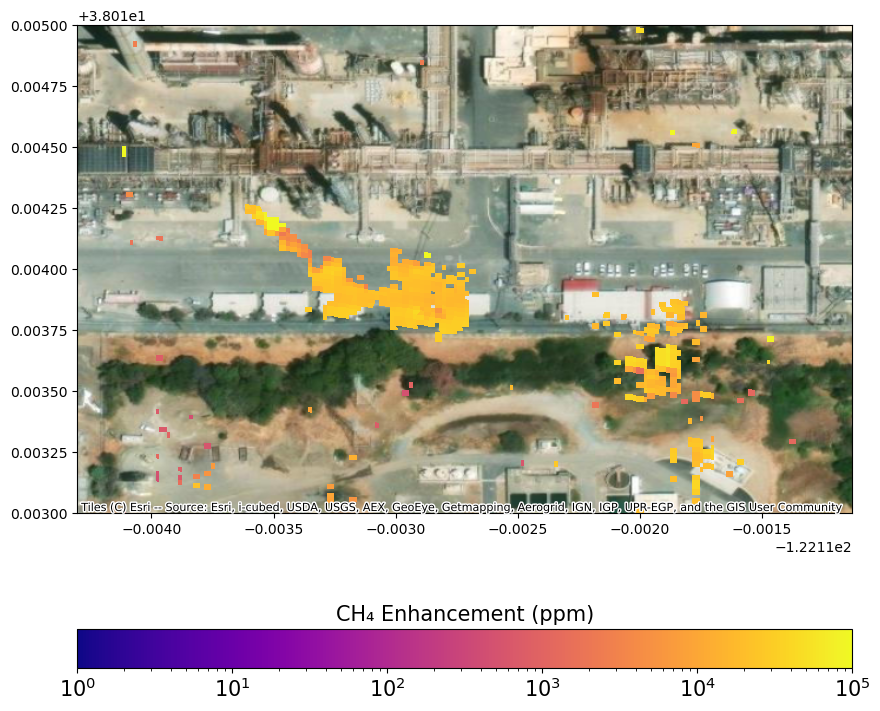

In [185]:
# Now that we have a model of transmittance versus methane concentration, we can use it to find the concentration of methane at each pixel in our data set and create a colormesh to show the plume

# Data transmittance not flattened
observed_transmittance_2d = (data_L2S[:,:,7]/(Planck(wavelengths_um, data_temp+273)[:,:,7]))

# Find data concentrations but now in 2d
concs_2d = np.e ** ((observed_transmittance_2d - b)/a)

# Use ACE filter to get only significant (above threshold) values
conc_2d_ACE_filtered = np.where(((data_ACE[:, :, 66]<=-0.25) | (data_ACE[:, :, 66]>=0.25)), concs_2d, np.nan) 

# Plot colormesh of all significant methane pixels where the color corresponds to the ACE filtered concentration value
fig, ax = plt.subplots(figsize=(10, 10))

plot = ax.pcolormesh(longitudes, latitudes, conc_2d_ACE_filtered, norm=matplotlib.colors.LogNorm(vmin=1, vmax=10**5), cmap='plasma')

clb = plt.colorbar(plot, ax = ax, location='bottom')
clb.ax.tick_params(labelsize=15) 
clb.ax.set_title('CH\u2084 Enhancement (ppm)',fontsize=15)

ax.set_ylim(38.013, 38.015)

cx.add_basemap(ax, crs = "EPSG:4326", source=cx.providers.Esri.WorldImagery)

You may notice that these methane concentrations seem very high, showing almost pure methane (10^5 ppm) at even 100 m away from the plume source. We addressed this issue by making a baseline correction. We reasoned that if there is no methane then the observed radiance should be equal to the blackbody radiance, so the transmittance would be 1. Since there's a background methane concentration of ~2 ppm, we used our model to find that observed transmittance, which turned out to be 0.94. We then found a correction that would force the mean transmittance of pixels deemed "insignificant" by the ACE filter to be 0.94.

<img src='Images/baseline_correction.png' align='center' width='700px'>

In [186]:
transmittance_2ppm = np.log(2)*a + b
print(f'The transmittance at 2 ppm methane is: {transmittance_2ppm}')

The transmittance at 2 ppm methane is: 0.9423201272716226


In [187]:
# There is definitely a more computationally rigorous way to find the correction factor, but I used a manual gradient descent test and check method to get within 0.0001 precision
observed_transmittances = ((data_L2S[:,:,:])/(Planck(wavelengths, data_temp+273)[:,:,:]-493.6))
ACE_values = data_ACE[:, :, 66]

# Booleans to use ACE filter to sort significant and insignificant pixels
significant_ACE_bool = (ACE_values <= -0.25) | (ACE_values >= 0.25)
insignificant_ACE_bool = ~significant_ACE_bool

# Applying ACE booleans to transmittances
significant_ACE_trans = observed_transmittances[significant_ACE_bool]
insignificant_ACE_trans = observed_transmittances[insignificant_ACE_bool]

# Mean radiance and standard deviation of pixels at each wavelength
mean_sig_trans = np.mean(significant_ACE_trans, axis=0)
std_sig_trans = np.std(mean_sig_trans, axis=0)
mean_insig_trans = np.mean(insignificant_ACE_trans, axis=0)
std_insig_trans = np.std(mean_insig_trans, axis=0)

# Guess and check section
print(f'Target value: {transmittance_2ppm}')
print(f'Current value: {mean_insig_trans[7]}')

Target value: 0.9423201272716226
Current value: 0.9424689612606499


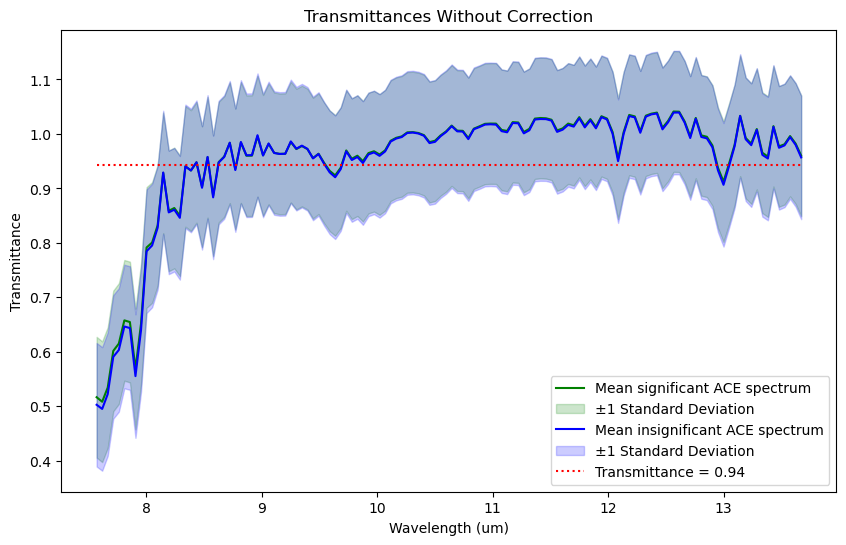

In [188]:
# Here is a plot of our transmittances without the correction factor
observed_transmittances = ((data_L2S[:,:,:])/(Planck(wavelengths, data_temp+273)[:,:,:]))

significant_ACE_trans = observed_transmittances[significant_ACE_bool]
insignificant_ACE_trans = observed_transmittances[insignificant_ACE_bool]

mean_sig_trans = np.mean(significant_ACE_trans, axis=0)
std_sig_trans = np.std(mean_sig_trans, axis=0)
mean_insig_trans = np.mean(insignificant_ACE_trans, axis=0)
std_insig_trans = np.std(mean_insig_trans, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(wavelengths, mean_sig_trans, color='g', label=f'Mean significant ACE spectrum')
plt.fill_between(wavelengths, mean_sig_trans - std_sig_trans, mean_sig_trans + std_sig_trans, color='g', alpha=0.2, label='±1 Standard Deviation')
plt.plot(wavelengths, mean_insig_trans, color='b', label=f'Mean insignificant ACE spectrum')
plt.fill_between(wavelengths, mean_insig_trans - std_insig_trans, mean_insig_trans + std_insig_trans, color='b', alpha=0.2, label='±1 Standard Deviation')

plt.hlines(transmittance_2ppm, xmin=wavelengths[0], xmax=wavelengths[-1], colors='red', linestyles='dotted', label='Transmittance = 0.94')

plt.xlabel('Wavelength (um)')
plt.ylabel('Transmittance')
plt.title('Transmittances Without Correction')
plt.legend()
plt.show()

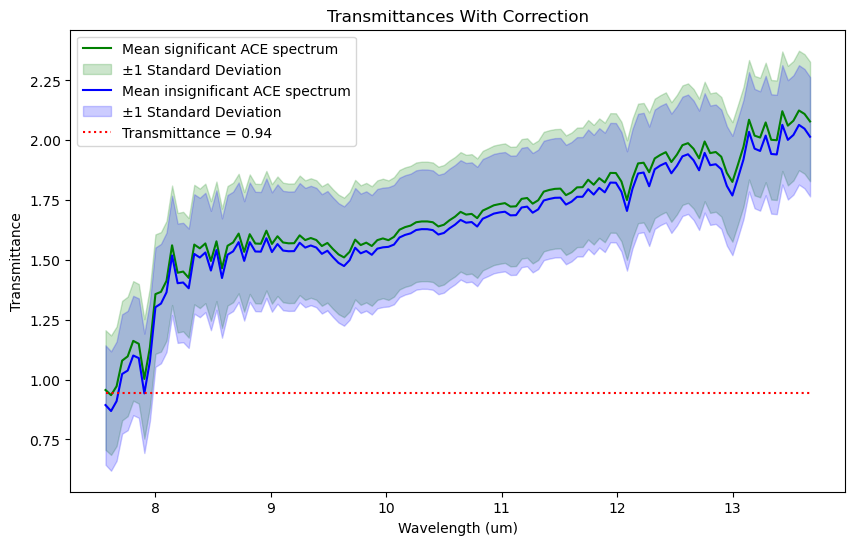

In [189]:
# And here is a plot of our transmittances WITH the correction factor. As you can see, the mean insignificant ACE transmittance at 7.91 um is 0.94.
observed_transmittances = ((data_L2S[:,:,:])/(Planck(wavelengths, data_temp+273)[:,:,:]-493.6))

significant_ACE_trans = observed_transmittances[significant_ACE_bool]
insignificant_ACE_trans = observed_transmittances[insignificant_ACE_bool]

mean_sig_trans = np.mean(significant_ACE_trans, axis=0)
std_sig_trans = np.std(mean_sig_trans, axis=0)
mean_insig_trans = np.mean(insignificant_ACE_trans, axis=0)
std_insig_trans = np.std(mean_insig_trans, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(wavelengths, mean_sig_trans, color='g', label=f'Mean significant ACE spectrum')
plt.fill_between(wavelengths, mean_sig_trans - std_sig_trans, mean_sig_trans + std_sig_trans, color='g', alpha=0.2, label='±1 Standard Deviation')
plt.plot(wavelengths, mean_insig_trans, color='b', label=f'Mean insignificant ACE spectrum')
plt.fill_between(wavelengths, mean_insig_trans - std_insig_trans, mean_insig_trans + std_insig_trans, color='b', alpha=0.2, label='±1 Standard Deviation')

plt.hlines(transmittance_2ppm, xmin=wavelengths[0], xmax=wavelengths[-1], colors='red', linestyles='dotted', label='Transmittance = 0.94')

plt.xlabel('Wavelength (um)')
plt.ylabel('Transmittance')
plt.title('Transmittances With Correction')
plt.legend()
plt.show()

/var/folders/25/8np84kys483f0_7dwd205zkh0000gn/T/ipykernel_60804/2097798483.py:3: RuntimeWarning: overflow encountered in power
  concs_2d = np.e ** ((observed_transmittance_2d - b)/a)
/var/folders/25/8np84kys483f0_7dwd205zkh0000gn/T/ipykernel_60804/2097798483.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = ax.pcolormesh(longitudes, latitudes, conc_2d_ACE_filtered, norm=matplotlib.colors.LogNorm(vmin=1, vmax=10**5), cmap='plasma')


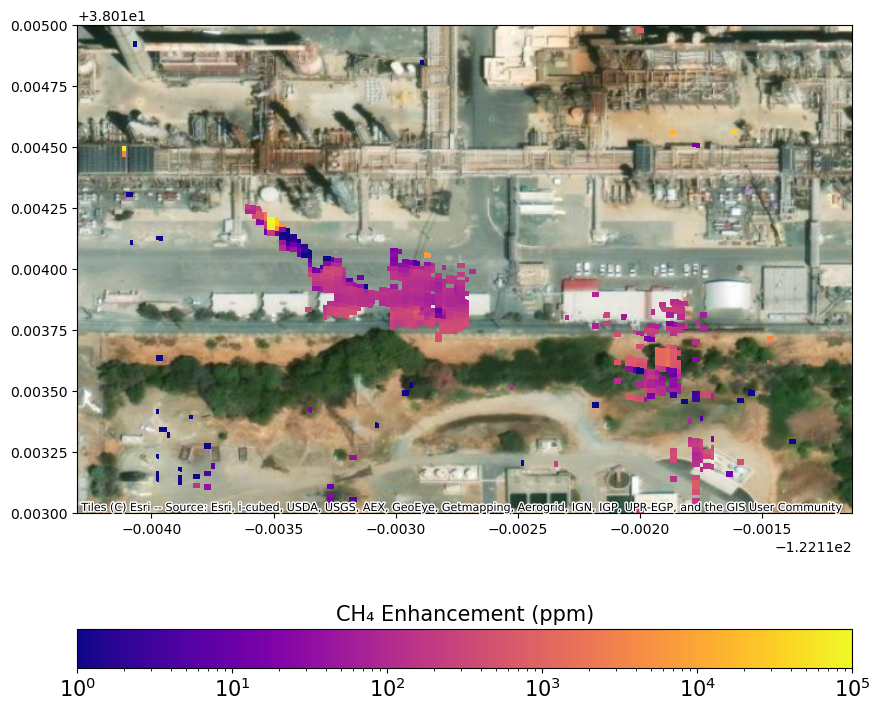

In [190]:
# Now that we have our baseline correction, we can get a more accurate colormesh of our plume's methane concentrations
observed_transmittance_2d = (data_L2S[:,:,7]/(Planck(wavelengths_um, data_temp+273)[:,:,7]-493.6))
concs_2d = np.e ** ((observed_transmittance_2d - b)/a)

conc_2d_ACE_filtered = np.where(((data_ACE[:, :, 66]<=-0.25) | (data_ACE[:, :, 66]>=0.25)), concs_2d, np.nan) 

fig, ax = plt.subplots(figsize=(10, 10))
plot = ax.pcolormesh(longitudes, latitudes, conc_2d_ACE_filtered, norm=matplotlib.colors.LogNorm(vmin=1, vmax=10**5), cmap='plasma')
clb = plt.colorbar(plot, ax = ax, location='bottom')
clb.ax.tick_params(labelsize=15) 
clb.ax.set_title('CH\u2084 Enhancement (ppm)',fontsize=15)
ax.set_ylim(38.013, 38.015)
cx.add_basemap(ax, crs = "EPSG:4326", source=cx.providers.Esri.WorldImagery)

---
## Quantification: converting from concentration of methane to mass flow rate

Buckland et. al. specifies that the mass flow rate for a chemical plume is obtained from $\frac{dM}{dt} = M \left( \frac{v}{l} \right)$, where v is the local wind speed, and l is the length of a reasonably well defined segment of the plume that contains a total mass M. So our first step is to designate an area of our plume that we believe to be "reasonably well defined." 

/var/folders/25/8np84kys483f0_7dwd205zkh0000gn/T/ipykernel_60804/2855638872.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = ax.pcolormesh(longitudes, latitudes, conc_2d_ACE_filtered, norm=matplotlib.colors.LogNorm(vmin=1, vmax=10**5), cmap='plasma')


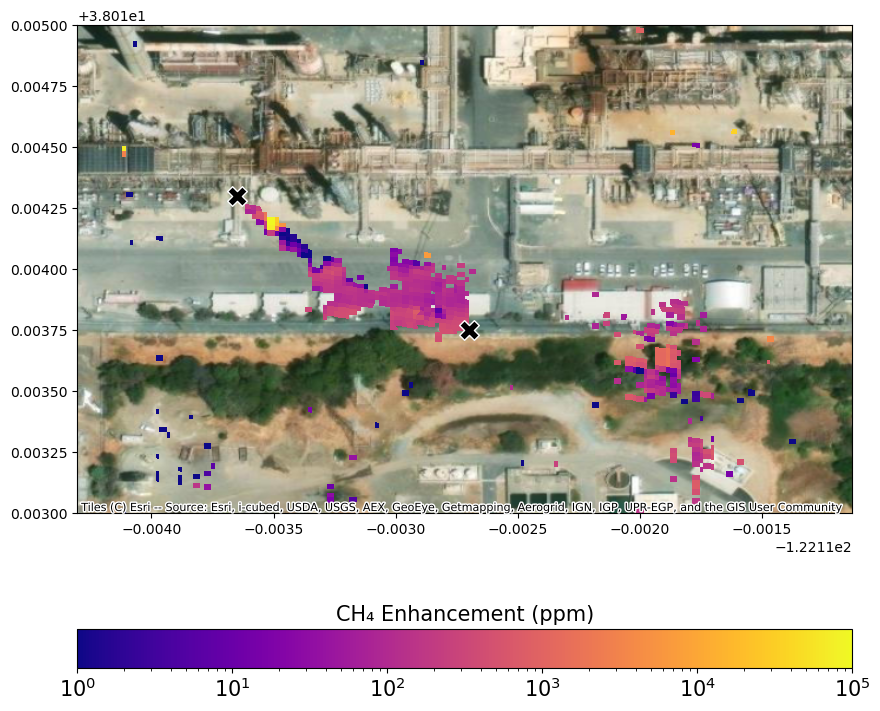

In [191]:
# Figure out which coordinates to use for the length of the plume
fig, ax = plt.subplots(figsize=(10, 10))
plot = ax.pcolormesh(longitudes, latitudes, conc_2d_ACE_filtered, norm=matplotlib.colors.LogNorm(vmin=1, vmax=10**5), cmap='plasma')
clb = plt.colorbar(plot, ax = ax, location='bottom')
clb.ax.tick_params(labelsize=15) 
clb.ax.set_title('CH\u2084 Enhancement (ppm)',fontsize=15)
ax.set_ylim(38.013, 38.015)
cx.add_basemap(ax, crs = "EPSG:4326", source=cx.providers.Esri.WorldImagery)

# Points
x1 = -122.11365
y1 = 38.0143
ax.scatter(x=x1, y=y1, s=200, c='black', edgecolors='white', marker='X')

x2 = -122.1127
y2 = 38.01375
ax.scatter(x=x2, y=y2, s=200, c='black', edgecolors='white', marker='X')

plt.show()

/var/folders/25/8np84kys483f0_7dwd205zkh0000gn/T/ipykernel_60804/2758884559.py:14: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = ax.pcolor(plume_lons, plume_lats, conc_2d_plume, norm=matplotlib.colors.LogNorm(), zorder=10, cmap='plasma')


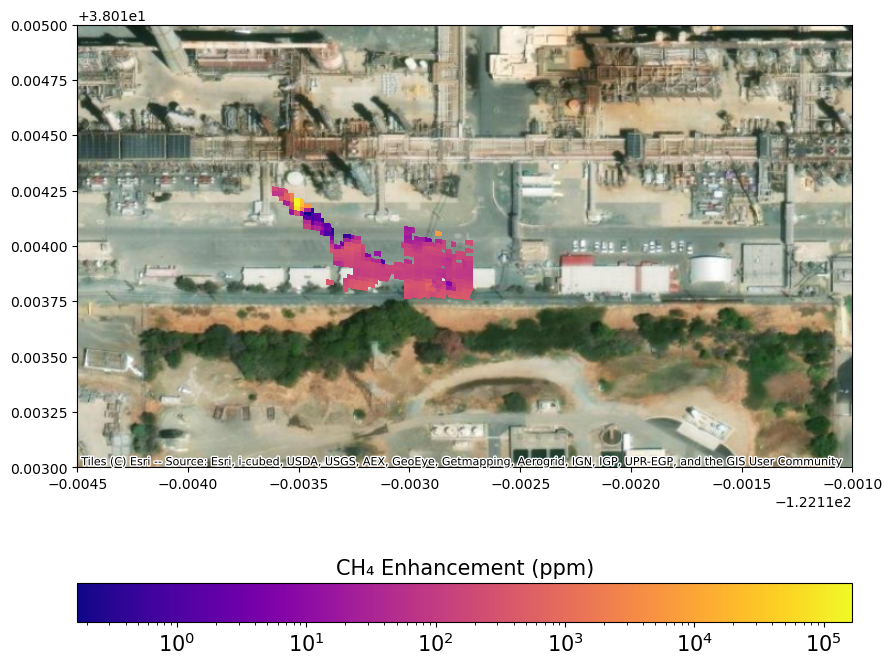

In [192]:
# Use 2d ACE filtered data and filter for the box of lats/lons encompassing the plume
conc_2d_plume = np.where((((latitudes > y2) & (latitudes < y1)) & ((longitudes < x2) & (longitudes > x1))), conc_2d_ACE_filtered, np.nan)

plume_lats = np.where(((latitudes > y2) & (latitudes < y1)), latitudes, np.nan)
plume_lons = np.where(((longitudes < x2) & (longitudes > x1)), longitudes, np.nan)

# Plot within the coordinates to confirm wer're using the desired area of the plume
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim(-122.1145, -122.1110)
ax.set_ylim(38.013, 38.015)
cx.add_basemap(ax, crs = "EPSG:4326", source=cx.providers.Esri.WorldImagery)

plot = ax.pcolor(plume_lons, plume_lats, conc_2d_plume, norm=matplotlib.colors.LogNorm(), zorder=10, cmap='plasma')
clb = plt.colorbar(plot, ax = ax, location='bottom',)
clb.ax.tick_params(labelsize=15) 
clb.ax.set_title('CH\u2084 Enhancement (ppm)',fontsize=15)
plt.show()

In [196]:
# Quantifying the plume - assuming ppm calculated is uniform throughout the volume of the pixel selected

# Calculate mass per square meter by integrating function using rho_0 = 1.2 kg/m^3, scale height h = 7.4 km, and bounds 0 km (ground) to 3.5 km (plane height)
f = lambda z: 1.2 * np.exp(-z/7400)
a, b = 0, 3500
result, error = quad(f, a, b)
print(f'Air mass per square meter: {result:.4f} kg/m^2')

# Result of integral is kg/m^2 so multiply by area of pixel (4 m^2) to get mass
air_mass = result*4
print(f'Air mass: {air_mass:.4f} kg')

# Total moles of air in one pixel (molar mass of air 28.9647 g/mol)
air_moles = air_mass*(1/28.9647)*1000
print(f'Air moles: {air_moles:.4f}')

# Moles of CH4 per pixel from ppm and moles of air
CH4_moles = (conc_2d_plume/(10**6))*air_moles

# Masses of CH4 from moles CH4 and CH4 molar mass, sum to get total mass (M) of CH4 in plume
CH4_masses = CH4_moles*16.0425/1000
M = np.nansum(CH4_masses)

# Mass flow rate (defined in eqn 40 of Buckland paper) = M(v/l), where v is the local wind speed, and l is the length of a reasonably well defined segment of the plume that contains a total mass M
v = 5/1000 # km/s
coords_1 = (y1, x1)
coords_2 = (y2, x2)
l = GD(coords_1, coords_2).km
print(f'Plume length: {l:.4f} km')
area = (GD((y2, x1), (y1, x1)).km)*(GD((y2, x1), (y2, x2)).km)
print(f'Plume rectangle area: {area:.4f} km^2')
mass_flow_rate = M*(v/l) # kg/s

# Results
print(f'Total mass CH4 = {M:.4f} kg')
print(f'Mass flow rate = {mass_flow_rate*60*60:.4f} kg/hr')
print(f'Max ppm: {np.nanmax(conc_2d_plume):.4f}')

Air mass per square meter: 3346.4554 kg/m^2
Air mass: 13385.8217 kg
Air moles: 462142.5963
Plume length: 0.1034 km
Plume rectangle area: 0.0051 km^2
Total mass CH4 = 3794.6378 kg
Mass flow rate = 660728.3733 kg/hr
Max ppm: 166463.8844


[Carbon Mapper](https://data.carbonmapper.org/?details=CH4_1A1_250m_-122.11414_38.01465%3Fstatus%3Dnot_deleted#16.5/38.014256/-122.113664) quantified a methane plume from this same location two years prior, on April 6, 2022. They recorded a source emission rate of 135 ± 45 kg CH4/hr.

Mass flow rate = 135 kg/hr
Max ppm: 6565.0703125


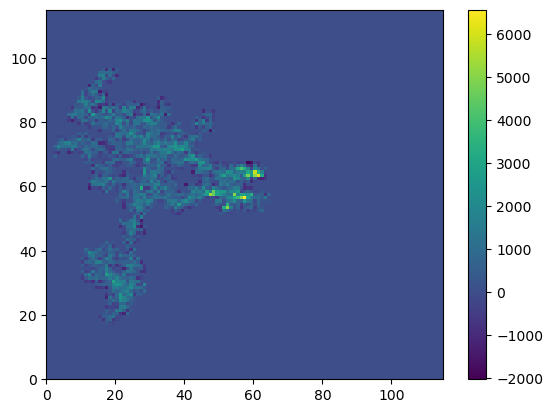

In [194]:
# Tif image of plume downloaded from CarbonMapper website
ds = rioxarray.open_rasterio("Images/carbon_mapper_methane_concentrations_2022-04-06.tif")
plt.pcolormesh(ds.values[0])
plt.colorbar()

# Carbon Mapper stats
print(f'Mass flow rate = 135 kg/hr')
print(f'Max ppm: {ds.values[0].max()}')

---
## Next Steps

Even with the correction, our calculations of mass flow rate and methane concentration are still off by a few orders of magnitude. Next steps for correcting this may be

* Collecting more rigorous MODTRAN data with different simulation inputs
* Finding other sources to characterize the relationship between concentration and transmittance for methane

Next steps for this project as a whole may be
* Utilizing this method to quantify other plumes detected by MAKO